# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np
#test
# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

In [2]:
#calculer des durées 
import datetime as dtt

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

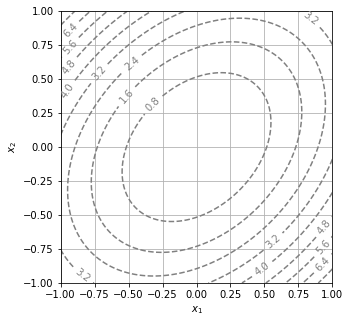

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

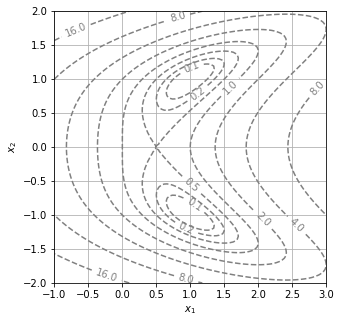

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

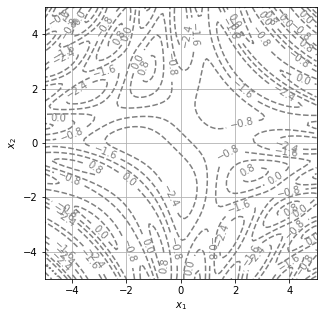

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 10**-10

In [15]:
#inverse d'une matrice 2x2
def inversion(matriceCarree) : 
    a,b,c,d = matriceCarree[0][0], matriceCarree[0][1], matriceCarree[1][0], matriceCarree[1][1]
    det = a*d-b*c 
    inv = np.array([[d,-b],[-c,a]])
    inv = inv/det
    return inv


**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [16]:
#premières étapes du calcul de la méthode de Newton
def inter(F,x0,y0,J): 
    jac = J(x0,y0)
    inv = inversion(jac)
    inte = -np.dot(inv,F(x0,y0))
    x = inte[0] + x0
    y = inte[1] + y0
    return (x,y)

def Newton(F, x0, y0, eps=10**-10, N=1000):
    J_f = J(F)
    #en ayant défini la jacobienne en tout point, on itère désormais pour trouver les valeurs successives de x et de y
    for i in range(N):
        #le calcul est similaire à celui en dimension 1, mais vectorisé
        (x,y) = inter(F,x0,y0,J_f)
        #test de précision
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    #si le calcul n'aboutit pas au bout de n étapes, on arrive en fin de boucle
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [17]:
#1er test
def aAnnuler(x,y):
    a = f1(x,y)-0.8
    b = x-y
    return np.array([a,b])

In [18]:
Newton(aAnnuler,0.8,0.8)

(0.4472135954999579, 0.4472135954999579)

In [19]:
#2e test 
#les points de référence 
tabRef = [[0.4,1.0],[1.0,0.4],[1.6,0.5],[-0.1,-0.3],[1.0,1.0]]
#on stocke les valeurs avant de les afficher
def NewtonDeux(F, x0, y0, eps=10**-10, N=100):
    J_f = J(F)
    absc = [x0]
    ordo = [y0]
    for i in range(N):
        #inter déjà défini
        (x,y) = inter(F,x0,y0,J_f)
        #stockage
        absc.append(x)
        ordo.append(y)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            print(x,y)
            return absc, ordo
        x0, y0 = x, y
    #si le calcul n'aboutit pas au bout de n étapes, on arrive en fin de boucle
    else:
        raise ValueError(f"no convergence in {N} steps.")


In [20]:
NewtonDeux(aAnnuler,0.8,0.8)

0.4472135954999579 0.4472135954999579


([0.8,
  0.525,
  0.4529761904761905,
  0.447250250297228,
  0.4472135970019964,
  0.4472135954999579,
  0.4472135954999579],
 [0.8,
  0.525,
  0.4529761904761905,
  0.447250250297228,
  0.4472135970019964,
  0.4472135954999579,
  0.4472135954999579])

0.447213595499958 0.447213595499958


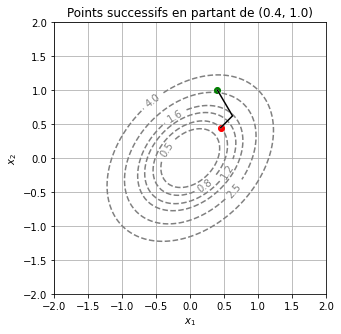

0.447213595499958 0.447213595499958


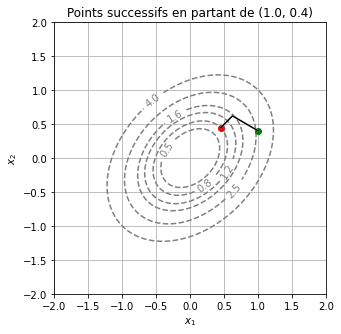

0.4472135954999579 0.4472135954999579


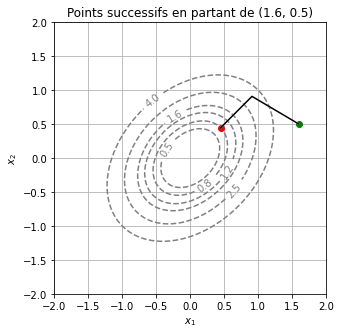

-0.447213595499958 -0.447213595499958


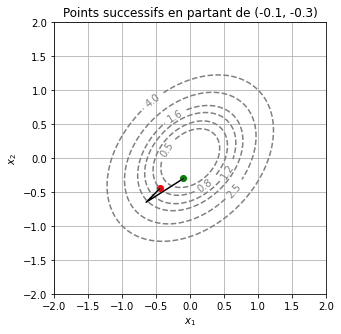

0.4472135954999579 0.4472135954999579


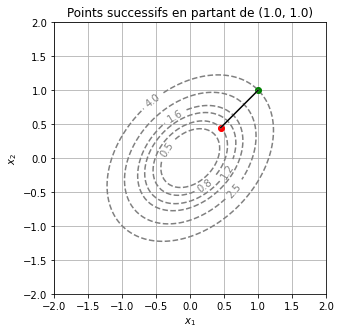

In [21]:
for point in tabRef:
    x0 = point[0] 
    x1 = point[1]
    
    points = NewtonDeux(aAnnuler, float(x0), float(x1))
    
    display_contour(f1,x=np.linspace(-2.0, 2.0, 100),y=np.linspace(-2.0, 2.0, 100),levels=[0.5, 0.8, 1.2, 1.6, 2.5, 4.0 ])
    
    #on commence au point vert
    plt.plot(points[0][0], points[1][0], "og")
    #on finit au point rouge 
    plt.plot(points[0][-1], points[1][-1], "or")
    #on affiche le chemin
    plt.plot(points[0], points[1], "w")
    plt.plot(points[0], points[1], "k")
    
    titre = "Points successifs en partant de (" + str(x0) + ", " + str(x1) + ")"
    plt.title(titre)
    plt.show()


0.4472135954999579 0.4472135954999579


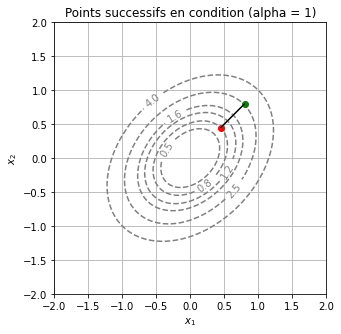

0.26967994498529685 0.5393598899705937


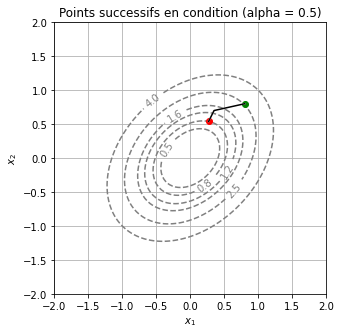

0.0 0.5163977794943222


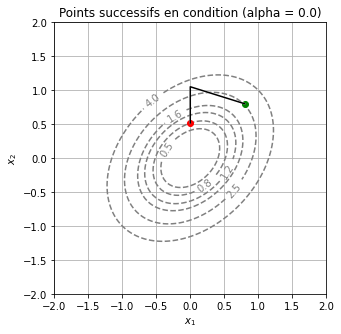

0.3757345746510897 -0.2504897164340598


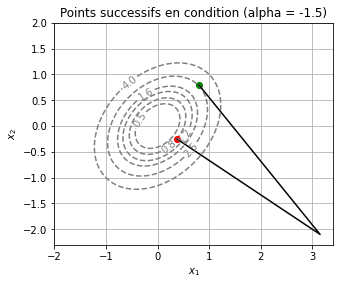

0.5393598899705937 0.26967994498529685


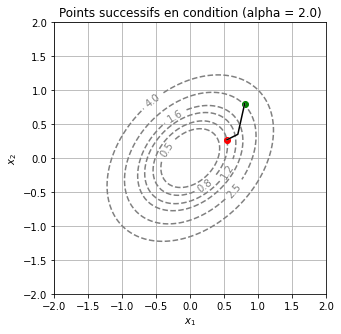

In [22]:
#3e test
#au lieu de se placer sur la droite x = y, on peut se placer sur une autre droite 

tabRefDeux = [1,0.5,0.0,-1.5,2.0]
for alpha in tabRefDeux:
    #pour chaque droite, on redéfinit la fonction en conséquence
    
    def aAnnulDeux(x,y):
        a = f1(x,y)-0.8
        b = x-alpha * y
        return np.array([a,b])
    points = NewtonDeux(aAnnulDeux, 0.8, 0.8)
    
    display_contour(f1,x=np.linspace(-2.0, 2.0, 100),y=np.linspace(-2.0, 2.0, 100),levels=[0.5, 0.8, 1.2, 1.6, 2.5, 4.0 ])
    
    #on commence au point vert
    plt.plot(points[0][0], points[1][0], "og")
    #on finit au point rouge 
    plt.plot(points[0][-1], points[1][-1], "or")
    #on affiche le chemin
    plt.plot(points[0], points[1], "w")
    plt.plot(points[0], points[1], "k")
    
    titre = "Points successifs en condition (alpha = "+str(alpha)+")"
    plt.title(titre)
    plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

On prend un point a(i), et il s'agira de trouver tout d'abord un point tel que :
- ce point est à distance delta de a(i)
- ce point est "à droite" du gradient
- ce point est proche de la courbe de niveau

Puis on applique la fonction Newton à ce point et on en déduit a(i+1).
On itère ensuite le processus n-1 fois pour trouver les autres points et tracer la courbe de niveau

In [55]:
# Fonction auxiliaire permettant de respecter les conditions de a(i+1) via la méthode de Newton

def fonction_pour_NEWTON(x0, y0, f, c,delta) :
    def g(x, y) :
        X = f(x, y) - c # condition à respecter
        # condition sur la distance entre les deux points, comme deuxieme composante de la fonction
        Y = (x0-x)**2 + (y0-y)**2 - delta**2
        return(np.array([X, Y]))
    return g


In [53]:
# Trouve le point situé après (x, y) à une distance delta

def suivant(x, y, f,c, delta = 0.1):
    # Calcul du point de départ, situé "un peu à droite" du point précédent
    gradient_i = grad(f)(x, y)
    
    norme_gradient_i = np.linalg.norm(gradient_i) #norme du gradient
    vect = np.array([gradient_i[1], -gradient_i[0]]) # ce vecteur et le gradient de f en a(i) forment une base orthogonale directe,
    # ainsi le décalage de delta pour delta très petit se trouve très proche de la courbe (car décalage orthogonal au gradient)
    vect *= (delta/norme_gradient_i)
    depx, depy = x + vect[0], y + vect[1] # vect vérifie l'exigence de distance car la norme de vect est celle du gradient de f en a(i)
    return Newton(fonction_pour_NEWTON(x, y, f, c,delta), depx, depy)


In [54]:
def level_curve(f, x0, y0, delta = 0.1, n = 1000, eps = 10**-10):
    c = f(x0,y0)
    X = [x0]
    Y = [y0]
    
    # initialisation
    xi = x0
    yi = y0

    for i in range(1, n):
        xi1, yi1 = suivant(xi, yi, f,c,delta)
        # on remplit X et Y avec des éléments sélectionnés par la méthode de la fonction "suivante"
        X.append(xi1)
        Y.append(yi1)
        xi = xi1
        yi = yi1
    return(np.array([X,Y]))



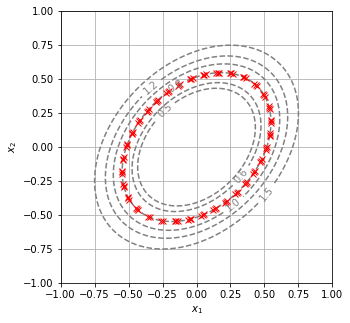

In [26]:
# Vérification avec f1

c = 0.8
x0, y0 = Newton(aAnnuler, -0.45, -0.45)
tab = level_curve(f1, x0, y0, n = 100)
display_contour(f1,x=np.linspace(-1.0, 1.0, 100),y=np.linspace(-1.0, 1.0, 100),levels=[0.5, 0.6, 0.8, 1.0, 1.2, 1.5 ])
plt.plot(tab[0], tab[1], 'rx')
plt.show()

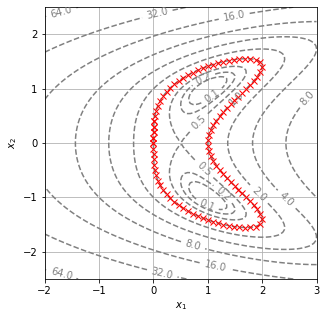

In [27]:
# Vérification avec f2

#initialisation
x0 = 0.0
y0 = 0.0
tab = level_curve(f2, x0, y0, n = 100)
display_contour(f2, x=np.linspace(-2.0, 3.0, 100), y=np.linspace(-2.5, 2.5, 100), levels=[2**i for i in range(-3, 8)])
plt.plot(tab[0], tab[1], 'rx')
plt.show()

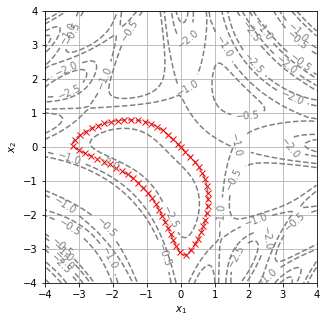

In [28]:
# Vérification avec f3

#initialisation
c = -2
x0 = 0.0
y0 = 0.0
tab = level_curve(f3, x0, y0, n = 61, delta = 0.2)
display_contour(f3, x=np.linspace(-4.0, 4.0, 100), y=np.linspace(-4.0, 4.0, 100),levels=[-3, -2.5, -2, -1, -0.5])
plt.plot(tab[0], tab[1], 'rx')
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [29]:
#Le signe de g(x,y) détermine la position relative du point vis-à-vis de la droite
def fonction(a,b,c,X): 
    return a*X[0] + b*X[1] + c 

#Les segments sont-ils en intersection ? 
def inters(aUn, bUn, aDeux, bDeux, delta = 0.1):
    #Croisement droite-segment
    #Equation de la 1e droite : g(x,y) = ax+by+c = 0 
    a = bUn[1] - aUn[1]
    b = aUn[0] - bUn[0]
    c = bUn[0]*aUn[1] - aUn[0]*bUn[1]

#Ici on introduit g définit dans le code précédent 



#Si même côté, pas de croisement
    if fonction(a, b, c, aDeux)*fonction(a, b, c, bDeux) >= 0 :
        return False

#Sinon, croisement segment-segment 
    else : 
#Cela a lui si et seulement s'il y a aussi croisement segment-droite dans l'autre sens 
#(En effet les deux intersections seraient alors intersection des deux mêmes droites, donc confondues)
        #Equation de la 1e droite : h(x,y) = dx+ey+f = 0
        d = bDeux[1] - aDeux[1]
        e = aDeux[0] - bDeux[0]
        f = bDeux[0]*aDeux[1] - aDeux[0]*bDeux[1]
        
        
        if fonction(d,e,f,aUn)*fonction(d,e,f,bUn) >= 0 :
            return False
        
        else :
            return True
#un petit test         
a = inters([0,0],[0,2],[1,1],[-1,1])
print(a)


True


In [109]:
# x0, y0 : point de départ pour obtenir les points de tracé de la courbe de niveau c
# delta : distance entre chaque point de la courbe de niveau
# n : nombre de points
# eps : l'eps de la méthode de Newton
# Cette fonction s'arrête une fois que l'on a fait un tour de la courbe de niveau 
def level_curve2(f, x0, y0, delta = 0.1, n = 15000, eps = eps):
    c= f(x0,y0)
    X = [x0]
    Y = [y0]
    
    premiere_iter = True

    A0 = [x0, y0]
    A1 = [x0, y0]
    
    xi = x0
    yi = y0

    for i in range(1, n):
        xi1, yi1 = suivant(xi, yi, f, c,delta)

        # Le nouveau segment
        An = [xi, yi]
        An1 = [xi1, yi1]
        
        if premiere_iter:
            premiere_iter = False
            A1 = [xi1, yi1]
        #On vérifie l'intersection 
        elif inters(A0, A1, An, An1,delta):
            return(np.array([X,Y]))
        X.append(xi1)
        Y.append(yi1)
        xi = xi1
        yi = yi1

    return(np.array([X,Y]))

def cercle_unite(x,y):
    return x**2 + y**2
level_curve2(cercle_unite,0.0,1.0)

array([[ 0.        ,  0.09987492,  0.19875109,  0.29563976,  0.38957202,
         0.47960856,  0.56484902,  0.64444099,  0.71758855,  0.78356022,
         0.84169629,  0.8914154 ,  0.93222035,  0.9637031 ,  0.98554882,
         0.99753905,  0.99955389,  0.99157319,  0.97367676,  0.94604356,
         0.90894993,  0.8627668 ,  0.807956  ,  0.74506564,  0.67472462,
         0.59763635,  0.51457173,  0.42636138,  0.33388742,  0.23807459,
         0.13988101,  0.04028862, -0.05970665, -0.15910486, -0.25691202,
        -0.35215006, -0.4438666 , -0.53114447, -0.6131109 , -0.68894622,
        -0.75789207, -0.81925901, -0.87243336, -0.91688337, -0.95216455,
        -0.97792408, -0.99390438, -0.99994562, -0.99598742, -0.98206934,
        -0.95833056, -0.92500848, -0.88243632, -0.83103979, -0.77133286,
        -0.70391261, -0.62945322, -0.54869931, -0.46245841, -0.37159291,
        -0.2770115 , -0.17965996, -0.08051183],
       [ 1.        ,  0.995     ,  0.98005   ,  0.9552995 ,  0.92099601,
   

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

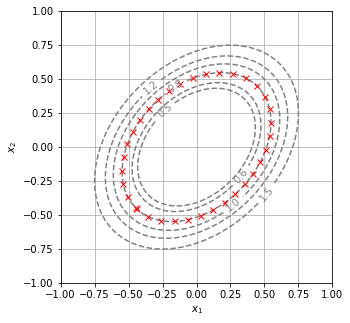

In [31]:
# Validation avec f1

# Choix de la courbe de niveau, et point initial
c = 0.8
x0, y0 = Newton(aAnnuler, -0.45, -0.45)
tab = level_curve2(f1, x0, y0, n = 500)

display_contour(f1,x=np.linspace(-1.0, 1.0, 100),y=np.linspace(-1.0, 1.0, 100),levels=[0.5, 0.6, 0.8, 1.0, 1.2, 1.5 ])
plt.plot(tab[0], tab[1], 'rx')
plt.show()

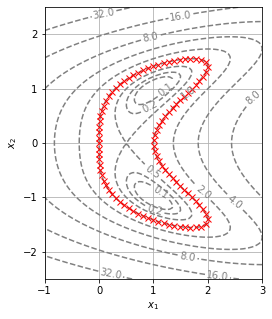

In [32]:
# Validation avec f2 :

# Choix de la courbe de niveau et du point initial
c = 1.0
x0 = 0.0
y0 = 0.0
tab = level_curve2(f2, x0, y0, n=500)

display_contour(f2, x=np.linspace(-1.0, 3.0, 100), y=np.linspace(-2.5, 2.5, 100), levels=[2**i for i in range(-3, 8)])
plt.plot(tab[0], tab[1], 'rx')
plt.show()

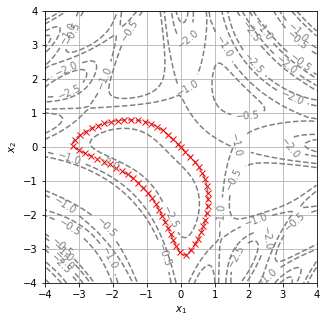

In [33]:
# Validation avec f3 :

# Choix de la courbe de niveau et du point initial
c = -2
x0 = 0.0
y0 = 0.0
tab = level_curve2(f3, x0, y0, delta = 0.2, n=500)

display_contour(f3, x=np.linspace(-4.0, 4.0, 100), y=np.linspace(-4.0, 4.0, 100),levels=[-3, -2.5, -2, -1, -0.5])
plt.plot(tab[0], tab[1], 'rx')
plt.show()

Les points représentés par des croix ne sont plus superposés : quelque soit le nombre de passage n, le programme s'arrête quand il a fait un tour de la courbe de niveau.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

Pour approximer l'aire d'une courbe de niveau à l'aide de la méthode des carrés, on procède comme suit :
- on crée un carré plus grand que la courbe de niveau, afin de "plonger" la courbe à l'intérieur
- on partitionne ce carré en petits carrés de coté h
- on regarde si le milieu de chaque petit carré est dans la courbe : ainsi, si il s'y trouve, on compte l'aire de ce petit carré
- on répète cela pour chaque petit carré, et en sommant les aires on obtient l'approximation voulue

In [59]:
eps = 10**-10
N=100

#la consigne demande de faire la méthode sans utiliser level_curve. On peut donc envisager de créer une fonction
# area_squarebis(f,c,h) en enlevant le calcul du carré à partir de level_curve, mais qui demanderait de donner en
# plus le centre du carré et son côté (en faisant attention de prendre un carré qui englobe la courbe de niveau)
# Cette méthode marche bien pour le cercle unité (prendre (0,0) comme centre et 1,1 comme coté par exemple),
# mais elle parait plus compliquée à utiliser pour des coubes plus complexes
# C'est pourquoi nous utiliserons la fonction suivante pour toutes les courbes :

def area_squares(f,c,h):
    delta = 0.1
    Ah=0
    def f_v2(x,y):
        return np.array([f(x,y)-c,x-y]) # conditions à respecter pour le 1er point
    x0,y0 = Newton(f_v2, 0.5,0.5,eps,N)
    courbe = level_curve2(f,x0,y0,delta)
    # on plonge la courbe dans un carré plus grand
    max_abs , min_abs = courbe[0,:].max() , courbe[0,:].min()
    max_ord , min_ord = courbe[1,:].max() , courbe[1,:].min()
    milAbs = (max_abs+min_abs)/2
    milOrd = (max_ord+min_ord)/2
    diffabs = max_abs-min_abs
    difford = max_ord - min_ord
    #coté du grand carré (on rajoute 0.1 pour être sur que le carré englobe la courbe, cette valeur ne change rien à l'aire trouvée)
    cote = max(diffabs, difford) +0.1
    for i in range(-int(cote/h),int(cote/h)):
        for j in range(-int(cote/h),int(cote/h)):
            if f(i*h+h/2 + milAbs, j*h+h/2 + milOrd)<=c:
                Ah+= h**2
    return Ah

def cercle_unite(x,y):
    return x**2 + y**2


print(area_squares(cercle_unite,1,10**-2))


3.142400000002207


In [80]:
def aire(h):
    return abs(area_squares(cercle_unite,1,h)-np.pi)

H=np.linspace(1,100,100)
X=1/H
Y=[]
for h in H :
    Y.append(aire(1/h))
plt.plot(X,Y)
plt.loglog(basex=10,basey=10)
plt.title("Erreur en fonction du pas h",fontsize=15)
plt.show()

KeyboardInterrupt: 

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [113]:
# Afin de faire l'encadrement, on prend comme borne sup la méthode précédente et comme borne inf la méthode suivante :
# On regarde pour chaque petit carré de coté h si tous ses sommets sont dans la courbe, et on ajoute son aire dans ce cas.

def area_squares2(f,c,h):
    delta = 0.1
    Ahmin=0
    def f_v2(x,y):
        return np.array([f(x,y)-c,x-y])
    x0,y0 = Newton(f_v2, 0.5,0.5,eps,N)
    courbe = level_curve2(f,x0,y0,delta)
    max_abs , min_abs = courbe[0,:].max() , courbe[0,:].min()
    max_ord , min_ord = courbe[1,:].max() , courbe[1,:].min()
    diffabs = max_abs - min_abs
    difford = max_ord - min_ord
    milAbs = (max_abs+min_abs)/2
    milOrd = (max_ord+min_ord)/2
    cote = max(diffabs, difford) + 0.1
    for i in range(-int(cote/h),int(cote/h)):
        for j in range(-int(cote/h),int(cote/h)):
  # On s'assure que les 4 côtés sont à l'intérieur          
            if f(i*h+h + milAbs,j*h+h + milOrd)<=c:
                if f(i*h+h + milAbs,j*h-h + milOrd)<=c:
                    if f(i*h-h + milAbs,j*h+h + milOrd)<=c:
                        if f(i*h-h + milAbs,j*h-h + milOrd)<=c:
                            Ahmin+= h**2
    return Ahmin


In [ ]:
def encadrement_squares(f,c,h):
    borneInf,borneSup = area_squares2(f,c,h),area_squares(f,c,h)
    print("L'aire est comprise entre ", borneSup, " et ", borneInf)
    print("Soit un écart entre les bornes de ", borneSup - borneInf)
encadrement_squares(cercle_unite,1,10**-3)

On a ainsi, pour un pas h=10^-3, un encadrement de l'aire de la courbe de niveau à 10^-2 près

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [116]:
#aire d'un triangle par la formule du parallélogramme
def rTri(p,z1,z):
    u = [p[0]-z1[0],p[1]-z1[1]]
    v = [p[0]-z[0],p[1]-z[1]]
    a, b, c, d = u[0], u[1], v[0], v[1]
    return (a*d-b*c)/2

#calcul de l'aire en disposant des points, et d'un point au centre 
def triangle(K):
    p = np.array([(K[0][0]+K[1][0])/2,(K[0][1]+K[1][1])/2])
    #convexe donc p à l'intérieur
    aireTot = 0
    n = len(K[0])
    
    for j in range(n-1):
        aire = rTri(p,(K[0][j+1],K[1][j+1]),(K[0][j],K[1][j]))
        aireTot += aire
        print(aireTot)
    aireTot += rTri(p,(K[0][0],K[1][0]),(K[0][n-1],K[1][n-1]))
    return aireTot 




In [92]:
#avant le cercle, le carré
triangle(np.array([[0,0,1,1],[0,1,1,0]]))

1.0

In [93]:
#maintenant, le cercle 
prelim = np.linspace(0,2*np.pi,1000)
#sens antitrigo, donc on va par le bas 
cercle = np.array([np.cos(prelim),-np.sin(prelim)])
triangle(cercle)

3.1415719413758416

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [40]:
#testons avec p extérieur, on va donner p à la main 
def triangleDeux(p,K):
    aireTot = 0
    n = len(K[0])
    
    for j in range(n-1):
        aire = rTri(p,(K[0][j+1],K[1][j+1]),(K[0][j],K[1][j]))
        aireTot += aire
    aireTot += rTri(p,(K[0][0],K[1][0]),(K[0][n-1],K[1][n-1]))
    return aireTot 


In [41]:
triangleDeux(np.array([2,2]),np.array([[0,0,1,1],[0,1,1,0]]))

1.0

In [42]:
triangleDeux(np.array([2,2]),cercle)

3.1415719413758487

In [43]:
#La méthode de calcul de l'aire permet d'avoir une aire négative quand l'ordre des vecteurs est permuté. 
#Ainsi, on calcule l'aire d'un polygone où on remplacerait les points "du côté de p" par p.
#Puis on retranche l'aire entre ces points et p
#Cela nécessite une méthode de calcul d'aire orientée : une première tentative de calcul d'aire par la méthode de Héron ne fonctionne pas. 

In [117]:
def triangleTrois(K):
    p = np.array([0,0])
    #p quelconque convient
    aireTot = 0
    n = len(K[0])
    
    for j in range(n-1):
        aire = rTri(p,(K[0][j+1],K[1][j+1]),(K[0][j],K[1][j]))
        aireTot += aire
    aireTot += rTri(p,(K[0][0],K[1][0]),(K[0][n-1],K[1][n-1]))
    return aireTot 

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [96]:
#on commence avec deux carrés
triangleTrois(np.array([[0,0,1,1,10,10,11,11],[0,1,1,0,10,11,11,10]]))
#comme pour la question précédente, il y a compensation 

2.0

In [97]:
#avec deux cercles, comme demandé 
cercleDeux = cercle + 10
tot = np.concatenate((cercle,cercleDeux),1)
triangleTrois(tot)

6.2831438827515385

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [114]:
#pas de modification à faire
def area_triangles(X,Y):
    K = np.array(X,Y)
    return triangleTrois(K)

#level-curve donne déjà un np.array de la bonne forme 
def aire_triangles(f, c, delta = 0.1, N = 100, eps = eps):
    def f_v2(x,y):
        return np.array([f(x,y)-c,x-y])
    x0,y0 = Newton(f_v2, 0.5,0.5,eps,N)
    courbe = level_curve2(f,x0,y0,delta)
    aireObt = triangleTrois(courbe)
    return aireObt 


In [120]:
def test_temps(f,c,delta):
    h = delta
    #h = delta/10 
    #(Attention, c'est plus long)
    #h est a priori redondant dans cette écriture, il a seulement un sens différent de delta
    tempsUn = dtt.datetime.now()
    print("Majoration pour les carrés ", area_squares(f,c,h))
    tempsDeux = dtt.datetime.now()
    print("Minoration pour les carrés ", area_squares2(f,c,h))
    tempsTrois = dtt.datetime.now()
    print("Approximation pour les triangles:", aire_triangles(f,c,delta))
    tempsQuatre = dtt.datetime.now()
    print("La méthode des carrés demande", tempsDeux-tempsUn, "pour la majoration,", tempsTrois - tempsDeux, "pour la minoration")
    print("Celle des triangles demande", tempsQuatre-tempsTrois)
    print("Résultats exprimés en heures:minutes:secondes")
test_temps(f1,0.8,0.01)
test_temps(f2,1.0,0.01)
test_temps(f3,-2.0,0.01)
    

Majoration pour les carrés  0.8897999999999183
Minoration pour les carrés  0.8442999999999233
Approximation pour les triangles: 0.8885243228760783
La méthode des carrés demande 0:00:00.906238 pour la majoration, 0:00:01.183853 pour la minoration
Celle des triangles demande 0:00:01.717415
Résultats exprimés en heures:minutes:secondes
Majoration pour les carrés  3.6706000000033217
Minoration pour les carrés  3.5497000000030665
Approximation pour les triangles: 3.6726674627483447
La méthode des carrés demande 0:00:01.341131 pour la majoration, 0:00:01.465816 pour la minoration
Celle des triangles demande 0:00:04.084702
Résultats exprimés en heures:minutes:secondes
Majoration pour les carrés  14.723199999979025
Minoration pour les carrés  14.146699999980369
Approximation pour les triangles: 7.058495870572181
La méthode des carrés demande 0:00:05.179758 pour la majoration, 0:00:07.837684 pour la minoration
Celle des triangles demande 0:00:07.100650
Résultats exprimés en heures:minutes:secon

In [48]:
#La méthode des carrés permet de fournir un encadrement si besoin, tandis que celle des triangles ne fournit qu'une approximation
#Par contre, quand la courbe n'est plus convexe, la méthode des carrés donne des résultats incohérents :
#on ne prend plus l'intérieur de la courbe, mais on résout une équation

#En terme de précision, le résultat exact est de 0.888577, la méthode des triangles est ici meilleure.  
#En prenant delta plus petit, la méthode des triangles a parfoisdu mal à repérer les croisements, et s'arrête prématurément. 
#Si on veut une encore meilleure précision, la méthode des carrés marchera mieux

#Enfin, pour la rapidité, la méthode des triangles est plus rapide que celle des carrés A PRECISION EGALE. 
#C'est d'autant plus vrai que la forme est complexe. 
#La méthode des triangles est de complexité O(1/delta) 
#Celle des carrés en O((1/h)**2), car on passe deux boucles for 
#On passe d'une complexité linéaire à une complexité quadratique, d'où la différence en terme de vitesse.

#On peut peut-être faire un peu mieux, par exemple pour area_squares2 en construisant à l'avance un tableau de booléens 
#pour ne pas avoir à faire 4 fois chaque calcul